# Library import

In [1]:
import copy, os, pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# data load
 - 각 종목별 종가 데이터만 추출 후, 종목명을 key로하여 dictionary로 저장

In [2]:
# set local data folder path
os.chdir("./data")

In [3]:
stock_dict = {}
for stock_path in os.listdir():
    if os.path.isfile(stock_path) and stock_path.endswith('.xlsx'):
        tmp = pd.read_excel(stock_path)
        stock_name = stock_path.split(".xlsx")[0]
        stock_dict[stock_name] = {'data':tmp[['날짜','종가']].values}

# data preprocessing
- train/validation/test split
- LSTM 학습 형태로 변환(전날 -> 다음날 예측)

In [4]:
def transform_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        tmp = data[i:(i + time_step), 0]
        X.append(tmp)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


stock_dict_tmp = copy.deepcopy(stock_dict)
for key in stock_dict.keys():
    data = stock_dict_tmp[key]['data'][:,1]

    # train/validation/test split
    train_size = int(0.8 * len(data))
    val_size = int(0.1 * len(data))
    test_size = len(data) - train_size - val_size

    stock_dict_tmp[key]['train'] = data[:train_size]
    stock_dict_tmp[key]['validation'] = data[train_size:train_size+val_size]
    stock_dict_tmp[key]['test'] = data[train_size+val_size:]

    # MinMaxScaling
    # fit for train, transform for train, validation, test
    scaler = MinMaxScaler()
    scaler = scaler.fit(stock_dict_tmp[key]['train'].reshape(-1,1))
    train_scaled = scaler.transform(stock_dict_tmp[key]['train'].reshape(-1,1))
    val_scaled = scaler.transform(stock_dict_tmp[key]['validation'].reshape(-1,1))
    test_scaled = scaler.transform(stock_dict_tmp[key]['test'].reshape(-1,1))

    stock_dict_tmp[key]['scaler'] = scaler
    stock_dict_tmp[key]['train_scaled'] = train_scaled
    stock_dict_tmp[key]['val_scaled'] = val_scaled
    stock_dict_tmp[key]['test_scaled'] = test_scaled

    # # LSTM 학습 형태 변환
    # 전날 -> 다음날 1일치
    time_steps = 1
    X_train, y_train = transform_data(stock_dict_tmp[key]['train_scaled'], time_steps)
    X_val, y_val = transform_data(stock_dict_tmp[key]['val_scaled'], time_steps)
    X_test, y_test = transform_data(stock_dict_tmp[key]['test_scaled'], time_steps)

    stock_dict_tmp[key]['train_date'] = stock_dict_tmp[key]['data'][0:train_size-1,0]
    stock_dict_tmp[key]['X_train'] = torch.Tensor(X_train).unsqueeze(-1)
    stock_dict_tmp[key]['y_train'] = torch.Tensor(y_train).unsqueeze(-1)
    stock_dict_tmp[key]['val_date'] = stock_dict_tmp[key]['data'][train_size+1:train_size+val_size, 0]
    stock_dict_tmp[key]['X_val'] = torch.Tensor(X_val).unsqueeze(-1)
    stock_dict_tmp[key]['y_val'] = torch.Tensor(y_val).unsqueeze(-1)
    stock_dict_tmp[key]['test_date'] = stock_dict_tmp[key]['data'][train_size+val_size+1:, 0]
    stock_dict_tmp[key]['X_test'] = torch.Tensor(X_test).unsqueeze(-1)
    stock_dict_tmp[key]['y_test'] = torch.Tensor(y_test).unsqueeze(-1)


# model 학습

C:\Users\mintm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


현재 학습중인 종목 : BGF리테일
Epoch [1/300], Train Loss: 0.3255
Validation Loss: 0.1953 

Epoch [2/300], Train Loss: 0.2493
Validation Loss: 0.2820 

Epoch [3/300], Train Loss: 0.2540
Validation Loss: 0.3057 

Epoch [4/300], Train Loss: 0.2100
Validation Loss: 0.2377 

Epoch [5/300], Train Loss: 0.1710
Validation Loss: 0.1921 

Epoch [6/300], Train Loss: 0.1492
Validation Loss: 0.1653 

Epoch [7/300], Train Loss: 0.1269
Validation Loss: 0.1304 

Epoch [8/300], Train Loss: 0.0986
Validation Loss: 0.0883 

Epoch [9/300], Train Loss: 0.0684
Validation Loss: 0.0486 

Epoch [10/300], Train Loss: 0.0440
Validation Loss: 0.0260 

Epoch [11/300], Train Loss: 0.0332
Validation Loss: 0.0220 

Epoch [12/300], Train Loss: 0.0312
Validation Loss: 0.0217 

Epoch [13/300], Train Loss: 0.0315
Validation Loss: 0.0217 

Epoch [14/300], Train Loss: 0.0323
Validation Loss: 0.0221 

Epoch [15/300], Train Loss: 0.0329
Validation Loss: 0.0226 

Epoch [16/300], Train Loss: 0.0331
Validation Loss: 0.0227 

Epoch [17/300

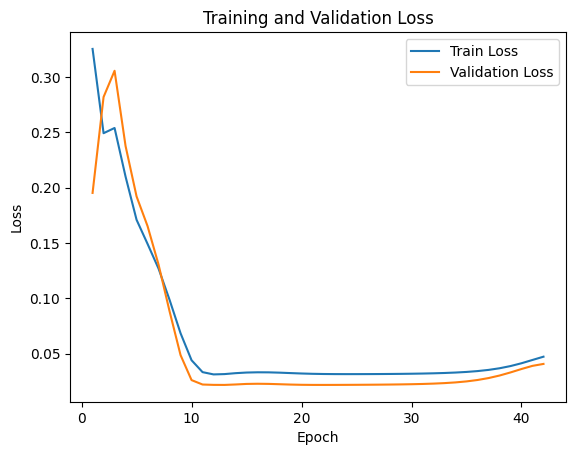

In [5]:
# LSTM model 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers,dropout=0.3,batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)

        for layer in range(num_layers):
            for weight in self.lstm._all_weights[layer]:
                if "weight" in weight:
                    nn.init.xavier_uniform_(getattr(self.lstm,weight))
                if "bias" in weight:
                    nn.init.uniform_(getattr(self.lstm,weight))

    def forward(self, x):
        # 매 배치마다 hidden,cell state를 0으로 초기화하여 이전 배치 영향이 없도록 반영
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))
        out = self.fc(hidden_state[ -1])
        return out

input_size = 1
hidden_size = 256
num_layers = 1
num_epochs = 300
batch_size = 64
learning_rate = 0.01
early_stopping_epochs = 20
early_stop_counter = 0

for key in ['BGF리테일']:
    folder_name = f"{key} 결과"
    if not os.path.exists(os.path.join("./", folder_name)):
        os.makedirs(os.path.join("./", folder_name))

    # DataLoader로 로드
    train_dataset = TensorDataset(stock_dict_tmp[key]['X_train'], stock_dict_tmp[key]['y_train'])
    val_dataset = TensorDataset(stock_dict_tmp[key]['X_val'], stock_dict_tmp[key]['y_val'])
    test_dataset = TensorDataset(stock_dict_tmp[key]['X_test'], stock_dict_tmp[key]['y_test'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMModel(input_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    print(f"현재 학습중인 종목 : {key}")
    best_loss = float('inf')
    train_loss_list = []
    val_loss_list = []
    # train
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_train_batch)
            loss = criterion(outputs, y_train_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = np.sqrt(train_loss / len(train_loader))
        train_loss_list.append(train_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}')

        # validation
        model.eval()
        valid_loss = 0.0
        predictions = []
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                output = model(X_val_batch)
                if len(output) == 1:
                    predictions.append(output.squeeze().tolist())
                else:
                    predictions.extend(output.squeeze().tolist())
                loss = criterion(output, y_val_batch)
                valid_loss += loss.item()
            valid_loss = np.sqrt(valid_loss / len(val_loader))
            val_loss_list.append(valid_loss)
        print(f'Validation Loss: {valid_loss:.4f}', "\n")

        # early stopping 적용
        if valid_loss > best_loss:
            early_stop_counter += 1
        else:
            best_loss = valid_loss
            early_stop_counter = 0

        if early_stop_counter >= early_stopping_epochs:
            print("Early Stop")
            torch.save(model, f'./{key} 결과/best_model.pt')
            break

    # loss graph
    plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, len(train_loss_list) + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f'./{key} 결과/loss_graph.png')
    plt.show()

    # train/validation/test set에 대한 예측 결과 및 scaler 저장
    def get_predictions(loader):
        prediction = []
        true = []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                outputs = model(X_batch)
                if len(outputs) == 1:
                    prediction.append(outputs.squeeze().tolist())
                else:
                    prediction.extend(outputs.squeeze().tolist())
                if len(y_batch) == 1:
                    true.append(y_batch.squeeze().tolist())
                else:
                    true.extend(y_batch.squeeze().tolist())
        return np.array(prediction).reshape(-1,1), np.array(true).reshape(-1,1)

    train_predict, train_labels = get_predictions(train_loader)
    val_predict, val_labels = get_predictions(val_loader)
    test_predict, test_labels = get_predictions(test_loader)

    # Helper function to match the length of dates with predictions
    def match_dates_with_predictions(dates, predictions):
        return dates[-len(predictions):]

    # 맞춘 데이터 길이
    train_dates = match_dates_with_predictions(stock_dict_tmp[key]['train_date'], train_labels)
    val_dates = match_dates_with_predictions(stock_dict_tmp[key]['val_date'], val_labels)
    test_dates = match_dates_with_predictions(stock_dict_tmp[key]['test_date'], test_labels)
    
    train_result = pd.DataFrame()
    train_result['Date'] = train_dates
    train_result['Actual Closing Price'] = stock_dict_tmp[key]['scaler'].inverse_transform(train_labels).round().astype(int)
    train_result['Forecast Closing Price'] = stock_dict_tmp[key]['scaler'].inverse_transform(train_predict).round().astype(int)
    val_result = pd.DataFrame()
    val_result['Date'] = val_dates
    val_result['Actual Closing Price'] = stock_dict_tmp[key]['scaler'].inverse_transform(val_labels).round().astype(int)
    val_result['Forecast Closing Price'] = stock_dict_tmp[key]['scaler'].inverse_transform(val_predict).round().astype(int)
    test_result = pd.DataFrame()
    test_result['Date'] = test_dates
    test_result['Actual Closing Price'] = stock_dict_tmp[key]['scaler'].inverse_transform(test_labels).round().astype(int)
    test_result['Forecast Closing Price'] = stock_dict_tmp[key]['scaler'].inverse_transform(test_predict).round().astype(int)

    train_result.to_csv(f'./{key} 결과/./{key}_train_result.csv',index=False)
    val_result.to_csv(f'./{key} 결과/./{key}_val_result.csv',index=False)
    test_result.to_csv(f'./{key} 결과/./{key}_test_result.csv',index=False)
    pickle.dump(stock_dict_tmp[key]['scaler'], open(f'./{key} 결과/scaler.pickle', mode='wb'))
    pickle.dump(stock_dict_tmp[key], open(f'./{key} 결과/total_dict.pickle', mode='wb'))

In [6]:
import pandas as pd
from datetime import datetime, timedelta
import torch
import pickle
import numpy as np
import os

def predict_future_prices(model, last_close_price, scaler_path, days=10):
    model.eval()
    tmp = []

    # scaler 불러오기
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 어제자 종가를 정규화
    last_close_price_scaled = scaler.transform(np.array(last_close_price).reshape(-1, 1))

    # 예측을 위한 입력 데이터 초기화
    current_input = torch.FloatTensor(last_close_price_scaled).view(1, 1, 1)  # 배치, 시퀀스 길이, 피처 개수

    for i in range(days):
        # 모델을 사용하여 다음날 종가 예측
        with torch.no_grad():
            predicted_price = model(current_input)

        # 예측 결과를 tmp에 저장
        tmp.append(predicted_price.item())

        # 예측 결과를 다음 입력으로 사용 (정규화된 값을 그대로 사용)
        current_input = torch.FloatTensor([[predicted_price.item()]]).view(1, 1, 1)  # 예측된 값을 다시 입력으로 사용

    # 예측된 값들을 원래 값으로 변환하고 정수로 변환
    future_prices = scaler.inverse_transform(np.array(tmp).reshape(-1, 1)).round().astype(int)

    return future_prices

def generate_future_dates(start_date, days):
    future_dates = []
    current_date = start_date
    while len(future_dates) < days:
        current_date += timedelta(days=1)
        if current_date.weekday() < 5:  # 주말 제외 (월요일=0, ..., 금요일=4)
            future_dates.append(current_date)
    return future_dates

# 여러 종목에 대한 미래 3일치 예측
keys = ['BGF리테일']
future_days = 3
predictions = {}

for key in keys:
    last_close_price = stock_dict[key]['data'][-1][1]
    scaler_path = f'./{key} 결과/scaler.pickle'
    model = torch.load(f'./{key} 결과/best_model.pt')
    future_prices = predict_future_prices(model, last_close_price, scaler_path, days=future_days)
    predictions[key] = future_prices

for key, future_prices in predictions.items():
    print(f"{key}의 미래 {future_days}일치의 예측 종가:")
    print(future_prices)

    # 기존 test_result.csv 파일 읽기
    test_result_path = f'./{key} 결과/{key}_test_result.csv'
    test_result = pd.read_csv(test_result_path, dtype={'Date': str})

    # 기존 날짜 읽기 및 새로운 날짜 생성
    last_date_str = test_result['Date'].iloc[-1]
    initial_date_str = stock_dict[key]['data'][-1][0].strftime("%Y-%m-%d")  # 초기값을 문자열로 변환
    
    if last_date_str == initial_date_str:
        # 첫 번째 실행 시: 정상적으로 수행
        last_date = datetime.strptime(last_date_str, "%Y-%m-%d")

        future_dates = generate_future_dates(last_date, future_days)
        future_dates_str = [date.strftime("%Y-%m-%d") for date in future_dates]

        # 예측한 종가와 날짜를 'Forecast Closing Price' 열에 추가
        future_prices_df = pd.DataFrame({
            'Date': future_dates_str,
            'Forecast Closing Price': future_prices.flatten()
        })

        extended_test_result = pd.concat([test_result, future_prices_df], ignore_index=True)

    else:
        # 두 번째 이후 실행 시: 추가된 종가 데이터에 덮어쓰기
        future_dates = test_result['Date'][-future_days:].tolist()  # 마지막 10일치 날짜 가져오기

        future_prices_df = pd.DataFrame({
            'Date': future_dates,
            'Forecast Closing Price': future_prices.flatten()
        })

        # 기존 test_result에서 마지막 10일치 데이터 제거 후 덮어쓰기
        extended_test_result = pd.concat([test_result[:-future_days], future_prices_df], ignore_index=True)

    # 파일에 저장
    output_dir = r'C:\Users\mintm\Documents\GitHub\Stock_Project\Joljak\data\Alist'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output_path = os.path.join(output_dir, f'{key}_test_result.csv')
    extended_test_result.to_csv(output_path, index=False)


BGF리테일의 미래 3일치의 예측 종가:
[[126529]
 [134654]
 [142173]]
